<a href="https://colab.research.google.com/github/jcazti/Poc_Pisai/blob/main/Poc_PISAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PisAi – Notebook Final (Pipeline completo)
_Projeto: Prevenção de lesões em corredores usando visão computacional e ML_

**Data de geração:** 2025-10-19 03:19:51  
**Autor:** João Carlos Araújo de Azevedo  
**Repositório GitHub (preencher):** `https://github.com/jcazti/Poc_Pisai`

> **Execução**: Rode cada seção na ordem. O notebook cria/atualiza a pasta `artifacts/` com modelo, métricas e imagens.


## 0. Reprodutibilidade & Ambiente
- Definimos sementes aleatórias fixas para garantir a reprodutibilidade dos resultados.
- Registramos versões das bibliotecas e caminhos de execução.
- Todos os arquivos do projeto devem estar na mesma pasta do notebook.


In [60]:
# ================== ITEM 0 – SETUP DO AMBIENTE PISAI ==================
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/PisAi_PoC_13/pisai_poc

# Instalação de dependências
!pip install -q streamlit==1.32.0 mediapipe opencv-python

# Imports principais
import os, sys, random, json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import platform
import sklearn

# Testa o Streamlit
import streamlit as st
print("Streamlit versão:", st.__version__)

# Reprodutibilidade
random.seed(42)
np.random.seed(42)

BASE_DIR = Path('.').resolve()
print('Python:', platform.python_version())
print('OS:', platform.platform())
print('Matplotlib:', matplotlib.__version__)
print('scikit-learn:', sklearn.__version__)

print('\nArquivos no diretório atual:')
for p in sorted(BASE_DIR.iterdir()):
    print('-', p.name)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PisAi_PoC_13/pisai_poc
Streamlit versão: 1.32.0
Python: 3.12.12
OS: Linux-6.6.105+-x86_64-with-glibc2.35
Matplotlib: 3.10.0
scikit-learn: 1.6.1

Arquivos no diretório atual:
- Vídeo do WhatsApp de 2025-10-17 à(s) 13.20.44_6c4d94b5.mp4
- __init__.py
- __pycache__
- app_streamlit.py
- artifacts
- config.py
- dataset.csv
- features.py
- infer.py
- report.py
- reports
- ric_prepare.py
- train.py
- user_features.py
- user_meta
- video_pose.py
- video_report.py


In [61]:
\
# ====== Configuração do ambiente no Colab (executar uma vez) ======
import sys, os, subprocess, importlib
from pathlib import Path
# Função auxiliar para instalar pacotes, se necessário
def _pip(pkg):
    try:
      # Tenta importar o pacote — se já estiver instalado, apenas confirma
        importlib.import_module(pkg.split('==')[0].split('[')[0])
        print(f'✔ {pkg} já instalado')
    except Exception:
      # Caso contrário, instala o pacote silenciosamente via pip
        print(f'Instalando {pkg}...');
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Pacotes necessários para treino/explicabilidade
# Essa parte garante que as principais bibliotecas usadas no notebook
# estejam disponíveis no ambiente Colab.
for pkg in ["xgboost", "shap", "joblib", "tqdm"]:
    _pip(pkg)

# Garantir que o diretório atual está no sys.path
proj_dir = Path('.').resolve()
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))
print("sys.path OK:", proj_dir)


✔ xgboost já instalado
✔ shap já instalado
✔ joblib já instalado
✔ tqdm já instalado
sys.path OK: /content/drive/MyDrive/PisAi_PoC_13/pisai_poc


## 1. Definição do problema
**Contexto:** lesões por sobrecarga em corrida impactam performance e saúde. Propomos rastrear risco de lesão a partir de **vídeos** (pose/landmarks) e metadados do atleta.

**Objetivo:** classificar **risco de lesão (0/1)** com base em _keypoints_ e variáveis antropométricas.
- Classe 0 → indivíduos sem risco de lesão
- Classe 1 → indivíduos com risco de lesão

**Personas:** treinadores, fisioterapeutas e atletas.  
**Perguntas:** quais padrões biomecânicos mais contribuem para o risco? Qual desempenho (AUC/F1) alcançamos?


## 2. Criação ou referência do dataset
- Origem: Running Injury Clinic (RIC) – vídeos e metadados (corrida/marcha).  
- `ric_prepare.py` gera um `dataset.csv` consolidando rótulos a partir de metadados.
- Aqui carregamos `dataset.csv` e inspecionamos as colunas e a estrutura.


In [62]:
\
# ====== Carregamento robusto do dataset (compatível com Colab) ======
import os, sys, urllib.request
from pathlib import Path
import pandas as pd

def _is_colab():
    return 'google.colab' in sys.modules

def _ensure_from_url(url: str, out: str = 'dataset.csv'):
    try:
        if url:
            print(f"Baixando dataset de: {url}")
            urllib.request.urlretrieve(url, out)
            return Path(out)
    except Exception as e:
        print(f"[Aviso] Falha ao baixar de URL: {e}")
    return None

def _try_drive_default():
    # Caminhos comuns no Drive — ajuste se necessário
    candidates = [
        '/content/drive/MyDrive/PisAi/dataset.csv',
        '/content/drive/MyDrive/dataset.csv',
    ]
    for c in candidates:
        p = Path(c)
        if p.exists():
            return p
    return None

# 1) Caminho padrão (local)
DATASET_PATH = Path('dataset.csv')

# 2) Se não existir, tente variável de ambiente com URL
if not DATASET_PATH.exists():
    DATASET_URL = os.environ.get('PISAI_DATASET_URL', '').strip()
    if DATASET_URL:
        p = _ensure_from_url(DATASET_URL, 'dataset.csv')
        if p and p.exists():
            DATASET_PATH = p

# 3) Se ainda não existir e estivermos no Colab, tente montar Drive ou abrir upload
if not DATASET_PATH.exists() and _is_colab():
    try:
        from google.colab import drive, files
        # Monta o Drive (idempotente)
        drive.mount('/content/drive', force_remount=False)
        p = _try_drive_default()
        if p is not None:
            DATASET_PATH = p
        else:
            print("dataset.csv não encontrado. Abra o seletor para upload...")
            uploaded = files.upload()  # abre seletor de arquivo
            if 'dataset.csv' in uploaded:
                DATASET_PATH = Path('dataset.csv')
    except Exception as e:
        print(f"[Aviso] Etapas automáticas do Colab falharam: {e}")

# 4) Checagem final
assert DATASET_PATH.exists(), (
    "dataset.csv não encontrado. "
    "Opções: (a) faça upload no Colab; (b) monte o Drive e ajuste o caminho; "
    "(c) defina PISAI_DATASET_URL para baixar automaticamente."
)

df = pd.read_csv(DATASET_PATH)
print('Dataset carregado de:', DATASET_PATH)
print('Linhas, colunas:', df.shape)
display(df.head(3))
print('\\nColunas:', list(df.columns))

# Estatística descritiva (numéricas)
display(df.describe(include='number').T.head(20))

# Classes (se houver)
if 'label' in df.columns:
    print('\\nContagem de classes:')
    print(df['label'].value_counts(dropna=False))


Dataset carregado de: dataset.csv
Linhas, colunas: (3920, 29)


,sub_id,datestring,filename,speed_r,age,Height,Weight,Gender,DominantLeg,InjDefn,...,YrsRunning,RaceDistance,RaceTimeHrs,RaceTimeMins,RaceTimeSecs,YrPR,NumRaces,source_meta,speed_w,label
0,100433,2010-10-05 13:22:40,20101005T132240.json,1.610861,53,NaN,NaN,Unknown,NaN,Training volume/intensity affected,...,13.0,10k,NaN,NaN,NaN,NaN,NaN,run_meta_data.csv,NaN,1
1,100434,2010-11-17 13:22:40,20101117T132240.json,2.237294,51,NaN,NaN,Female,NaN,Training volume/intensity affected,...,20.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN,run_meta_data.csv,NaN,1
2,100537,2012-07-03 10:25:50,20120703T102550.json,2.127441,255,173.1,67.6,Female,Right,2 workouts missed in a row,...,2.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN,run_meta_data.csv,NaN,1


\nColunas: ['sub_id', 'datestring', 'filename', 'speed_r', 'age', 'Height', 'Weight', 'Gender', 'DominantLeg', 'InjDefn', 'InjJoint', 'InjSide', 'SpecInjury', 'InjDuration', 'InjJoint2', 'InjSide2', 'SpecInjury2', 'Activities', 'Level', 'YrsRunning', 'RaceDistance', 'RaceTimeHrs', 'RaceTimeMins', 'RaceTimeSecs', 'YrPR', 'NumRaces', 'source_meta', 'speed_w', 'label']


,count,mean,std,min,25%,50%,75%,max
sub_id,3920.0,118233.591837,37703.018671,100001.000000,100606.000000,101142.000000,101659.250000,201225.000000
speed_r,1832.0,2.760160,0.477627,1.172048,2.482615,2.721310,2.933408,4.876998
age,3920.0,40.916327,14.110512,18.000000,30.000000,40.000000,51.000000,255.000000
Height,3854.0,170.989756,36.409066,0.000000,165.000000,172.000000,178.600000,999.000000
Weight,3885.0,71.101015,28.549419,0.000000,60.300000,69.800000,79.800000,1564.000000
InjDuration,763.0,466.698558,1416.518975,0.000000,60.000000,150.000000,365.000000,30000.000000
YrsRunning,2499.0,52.944578,200.364153,0.000000,3.000000,8.000000,15.000000,999.000000
YrPR,726.0,1916.559229,425.144897,0.000000,2012.000000,2012.000000,2012.000000,2016.000000
NumRaces,906.0,5.073951,5.501586,0.000000,2.000000,3.000000,7.000000,30.000000
speed_w,2088.0,1.201072,0.179117,0.392263,1.118876,1.161314,1.257764,2.729563


\nContagem de classes:
label
1    3172
0     748
Name: count, dtype: int64


## 3. Pré-processamento
- Limpeza, padronização e criação de _features_ derivadas (IMC, índices, simetria).  
- Divisão treino/teste (80/20).  
- **Visualização**: matriz de correlação (matplotlib).


In [63]:
# ====== Importar preprocess/treino com fallback ======
import importlib, textwrap, json, sys
from pathlib import Path

# Estamos em /content/drive/MyDrive/PisAi_PoC_13/pisai_poc
# O pacote 'pisai_poc' fica no diretório pai:
ROOT_DIR = Path.cwd().parent  # /content/drive/MyDrive/PisAi_PoC_13
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

spec_train = None

try:
    # 1ª tentativa: importar como pacote (usa imports relativos .config, .user_features)
    try:
        spec_train = importlib.import_module('pisai_poc.train')
        print("✔ Usando pisai_poc.train (pacote)")
    except ModuleNotFoundError:
        # 2ª tentativa: importar train.py direto (modo “solto”)
        spec_train = importlib.import_module('train')
        print("✔ Usando train.py local (módulo solto)")

except (ModuleNotFoundError, ImportError) as e:
    # Se deu qualquer erro (inclusive attempted relative import), cai no fallback
    print("⚠ Não foi possível importar train.py:", e)
    print("   Criando 'train_portable.py' como fallback...")

    portable_src = r"""
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import dump
import shap

# Fallback de caminhos
ARTIFACTS_DIR = Path('artifacts')

DROP_TEXT_COLS = [
    "datestring", "filename", "source_meta", "sub_id",
    "InjDefn", "InjJoint", "InjSide", "SpecInjury", "InjDuration",
    "InjJoint2", "InjSide2", "SpecInjury2",
    "Activities", "Level",
]

def _clean_numeric_series(s: pd.Series) -> pd.Series:
    # Limpa strings numéricas problemáticas:
    # - remove colchetes/parênteses/chaves
    # - troca vírgula por ponto
    # - converte notação científica como '5E-1'
    if s.dtype == "object":
        s = (
            s.astype(str)
             .str.replace(r"[\\[\\]\\(\\)\\{\\}]", "", regex=True)
             .str.replace(",", ".", regex=False)
             .str.strip()
        )
    return pd.to_numeric(s, errors="coerce")

def preprocess(df: pd.DataFrame):
    if "label" not in df.columns:
        raise ValueError("CSV precisa conter coluna 'label'.")

    y = df["label"].astype(int)

    # Remove colunas textuais irrelevantes + label
    X = df.drop(
        columns=[c for c in DROP_TEXT_COLS if c in df.columns] + ["label"],
        errors="ignore"
    ).copy()

    # Mapeamentos categóricos simples
    if "Gender" in X.columns:
        X["Gender"] = (
            X["Gender"].astype(str).str.upper()
            .map({"MALE": 1, "M": 1, "FEMALE": 0, "F": 0})
            .fillna(0)
        )

    if "DominantLeg" in X.columns:
        X["DominantLeg"] = (
            X["DominantLeg"].astype(str).str.upper()
            .map({"RIGHT": 1, "R": 1, "LEFT": 0, "L": 0})
            .fillna(0)
        )

    # Conversão robusta para numérico
    for c in X.columns:
        X[c] = _clean_numeric_series(X[c])

    # engineered features
    if all(col in X.columns for col in ["Weight", "Height"]):
        h = X["Height"].replace(0, np.nan)
        X["BMI"] = (X["Weight"] / (h**2)).fillna(0)

    if all(col in X.columns for col in ["speed_r", "Height"]):
        h = X["Height"].replace(0, np.nan)
        X["speed_norm"] = (X["speed_r"] / h).fillna(0)

    if all(col in X.columns for col in ["Weight", "speed_r"]):
        X["load_factor"] = X["Weight"] * X["speed_r"]

    if all(col in X.columns for col in ["cadence", "Weight"]):
        w = X["Weight"].replace(0, np.nan)
        X["cadence_weight_ratio"] = (X["cadence"] / w).fillna(0)

    knee_cols = [c for c in ["knee_l_mean", "knee_r_mean", "knee_mean"] if c in X.columns]
    if all(col in X.columns for col in ["Weight", "speed_r"]) and knee_cols:
        if "knee_mean" in X.columns:
            kmean = X["knee_mean"]
        else:
            a = X.get("knee_l_mean", 0)
            b = X.get("knee_r_mean", 0)
            kmean = (_clean_numeric_series(a).fillna(0) + _clean_numeric_series(b).fillna(0)) / 2.0

        denom = kmean.replace(0, np.nan)
        X["joint_stress_index"] = ((X["Weight"] * X["speed_r"]) / denom).fillna(0)

    if all(col in X.columns for col in ["stride_left", "stride_right"]):
        X["stride_symmetry"] = (X["stride_left"] - X["stride_right"]).abs()

    X = X.select_dtypes(include=["number"]).replace([np.inf, -np.inf], np.nan).fillna(0)

    if X.shape[1] == 0:
        raise ValueError("Nenhuma coluna numérica restou após a limpeza.")

    return X, y

def plot_roc(y_true, y_score, path):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC")
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curve")
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    plt.close()

def plot_cm(y_true, y_pred, path):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion matrix")
    plt.colorbar()
    plt.xticks([0, 1], [0, 1])
    plt.yticks([0, 1], [0, 1])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    plt.close()

def main(args):
    data = Path(args.data)
    outdir = Path(args.out) if args.out else ARTIFACTS_DIR
    outdir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(data)

    # user_data opcional
    user_data_path = Path('user_data.csv')
    if user_data_path.exists():
        du = pd.read_csv(user_data_path)
        df = pd.concat([df, du], ignore_index=True, sort=False)

    X, y = preprocess(df)

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    n_pos = int((ytr == 1).sum())
    n_neg = int((ytr == 0).sum())
    scale_pos_weight = (n_neg / n_pos) if n_pos > 0 else 1.0

    candidates = {
        "rf": Pipeline([
            ("sc", StandardScaler(with_mean=False)),
            ("rf", RandomForestClassifier(
                n_estimators=400,
                random_state=42,
                class_weight="balanced_subsample"
            ))
        ]),
        "xgb": XGBClassifier(
            n_estimators=600, max_depth=5, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9,
            eval_metric="logloss",
            random_state=42, n_jobs=-1,
            scale_pos_weight=scale_pos_weight
        )
    }

    best_name, best_auc, best_model = None, -1.0, None
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in candidates.items():
        scores = cross_val_score(model, Xtr, ytr, cv=cv, scoring="roc_auc")
        auc = float(scores.mean())
        if auc > best_auc:
            best_auc, best_name, best_model = auc, name, model

    best_model.fit(Xtr, ytr)

    proba = (
        best_model.predict_proba(Xte)[:, 1]
        if hasattr(best_model, "predict_proba")
        else best_model.decision_function(Xte)
    )

    auc_te = roc_auc_score(yte, proba)
    report = classification_report(yte, (proba >= 0.5).astype(int))

    dump(best_model, outdir / "model.joblib")
    feature_cols = list(X.columns)

    with open(outdir / "feature_columns.json", "w", encoding="utf-8") as f:
        json.dump(feature_cols, f, ensure_ascii=False, indent=2)

    with open(outdir / "metrics.txt", "w", encoding="utf-8") as f:
        f.write(f"Best model: {best_name} (cv AUC={best_auc:.3f})\n")
        f.write(f"Holdout AUC={auc_te:.3f}\n\n{report}\n")

    plot_roc(yte, proba, outdir / "roc_curve.png")
    plot_cm(yte, (proba >= 0.5).astype(int), outdir / "confusion_matrix.png")

    # ===================== SHAP (com tradução PT-BR) =====================
    try:
        if isinstance(best_model, Pipeline):
            est = best_model.steps[-1][1]
            pre = best_model[:-1]
            Xte_used = pre.transform(Xte)
        else:
            est = best_model
            Xte_used = Xte.values

        if hasattr(Xte_used, "toarray"):
            Xte_used = Xte_used.toarray()

        Xte_used = np.asarray(Xte_used, dtype=float)

        traducao = {
            "YrsRunning": "Anos correndo",
            "NumRaces": "Número de provas",
            "DominantLeg": "Perna dominante",
            "BMI": "IMC",
            "age": "Idade",
            "Weight": "Peso",
            "Height": "Altura",
            "speed_w": "Velocidade média (walk/run)",
            "speed_norm": "Velocidade normalizada",
            "YrPR": "Melhor performance no ano",
            "RaceTimeSecs": "Tempo de prova (s)",
            "speed_r": "Velocidade de corrida",
            "RaceTimeMins": "Tempo de prova (min)",
            "RaceTimeHrs": "Tempo de prova (h)",
            "Gender": "Sexo",
            "load_factor": "Fator de carga",
            "RaceDistance": "Distância da prova",
            "cadence_weight_ratio": "Cadência / peso",
            "joint_stress_index": "Índice de estresse articular",
            "stride_symmetry": "Assimetria de passada",
        }

        feature_names_pt = [traducao.get(col, col) for col in feature_cols]

        plt.figure()
        explainer = shap.TreeExplainer(est)
        shap_values = explainer(Xte_used)

        shap.summary_plot(
            shap_values,
            features=Xte_used,
            feature_names=feature_names_pt,
            show=False,
            plot_type="bar",
            max_display=20
        )
        plt.tight_layout()
        plt.savefig(outdir / "shap_summary_bar.png", dpi=160)
        plt.close()

        plt.figure()
        shap.summary_plot(
            shap_values,
            features=Xte_used,
            feature_names=feature_names_pt,
            show=False,
            max_display=20
        )
        plt.tight_layout()
        plt.savefig(outdir / "shap_beeswarm.png", dpi=160)
        plt.close()

    except Exception as e:
        print(f"[Aviso] Não foi possível gerar SHAP: {e}")

    print(f"Treinado {best_name} | CV AUC={best_auc:.3f} | Holdout AUC={auc_te:.3f}")
    print(f"Artefatos em: {outdir}")
"""

    Path('train_portable.py').write_text(portable_src, encoding='utf-8')
    importlib.invalidate_caches()
    spec_train = importlib.import_module('train_portable')
    print("✔ Fallback OK: usando train_portable.py")


✔ Usando pisai_poc.train (pacote)


## 4. Seleção e justificativa dos modelos
- **RandomForest**: robusto para dados tabulares, menos sensível a escala; interpretável via importância de variáveis.
- **XGBoost**: forte performance em classificação tabular; lida bem com desbalanceamento (scale_pos_weight).
Critério principal: **AUC-ROC** em validação cruzada + desempenho no holdout.


## 5. Algoritmo de treinamento e validação
Treinaremos via `train.py` e salvaremos artefatos na pasta `artifacts/`: modelo (`.joblib`), `feature_columns.json`, gráficos (`roc_curve.png`, `confusion_matrix.png`) e `metrics.txt`.

In [64]:
# Treino completo (usa train.main) com fallback para 'train_portable.py' no Colab
from types import SimpleNamespace
import importlib, sys
from pathlib import Path

# Estamos em /content/drive/MyDrive/PisAi_PoC_13/pisai_poc
proj_dir = Path('.').resolve()           # .../PisAi_PoC_13/pisai_poc
root_dir = proj_dir.parent              # .../PisAi_PoC_13

# Garante que o pacote pisai_poc seja visível
if str(root_dir) not in sys.path:
    sys.path.insert(0, str(root_dir))
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

train = None

try:
    # 1ª tentativa: importar como pacote (usa os imports relativos .config, .user_features)
    train = importlib.import_module('pisai_poc.train')
    print("✔ Usando pisai_poc.train (pacote)")
except (ModuleNotFoundError, ImportError) as e:
    print("⚠ Não consegui usar pisai_poc.train:", e)
    print("   Tentando fallback 'train_portable.py'...")

    try:
        # 2ª tentativa: usar train_portable.py (gerado pela célula de fallback do Item 8)
        train = importlib.import_module('train_portable')
        print("✔ Fallback OK: usando train_portable.py")
    except ModuleNotFoundError as e2:
        raise ModuleNotFoundError(
            "Nem 'pisai_poc.train' nem 'train_portable.py' puderam ser importados. "
            "Execute antes a célula de 'Importar preprocess/treino com fallback' para criar o train_portable.py."
        ) from e2

# Agora executa o treino
args = SimpleNamespace(
    data=str(proj_dir / 'dataset.csv'),
    out=str(proj_dir / 'artifacts')
)
train.main(args)

print('\nArquivos em artifacts/:')
for p in sorted((proj_dir / 'artifacts').iterdir()):
    print('-', p.name)

m = proj_dir / 'artifacts' / 'metrics.txt'
print('\nConteúdo de metrics.txt:')
print(m.read_text(encoding='utf-8') if m.exists() else 'metrics.txt não encontrado')


✔ Usando pisai_poc.train (pacote)


/content/drive/MyDrive/PisAi_PoC_13/pisai_poc/train.py:183: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=Xte_used, feature_names=feature_cols,
/content/drive/MyDrive/PisAi_PoC_13/pisai_poc/train.py:189: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=Xte_used, feature_names=feature_cols,


Treinado xgb | CV AUC=0.887 | Holdout AUC=0.904
Artefatos em: /content/drive/MyDrive/PisAi_PoC_13/pisai_poc/artifacts

Arquivos em artifacts/:
- Nova pasta
- confusion_matrix.png
- feature_columns.json
- metrics.txt
- model.joblib
- roc_curve.png
- shap_beeswarm.png
- shap_summary_bar.png

Conteúdo de metrics.txt:
Best model: xgb (cv AUC=0.887)
Holdout AUC=0.904

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       150
           1       0.94      0.91      0.92       634

    accuracy                           0.88       784
   macro avg       0.80      0.83      0.81       784
weighted avg       0.89      0.88      0.88       784




## 6. Medidas de desempenho
- **AUC-ROC**, **accuracy**, **precision**, **recall**, **F1**.  
- Exibição dos gráficos gerados no treino.

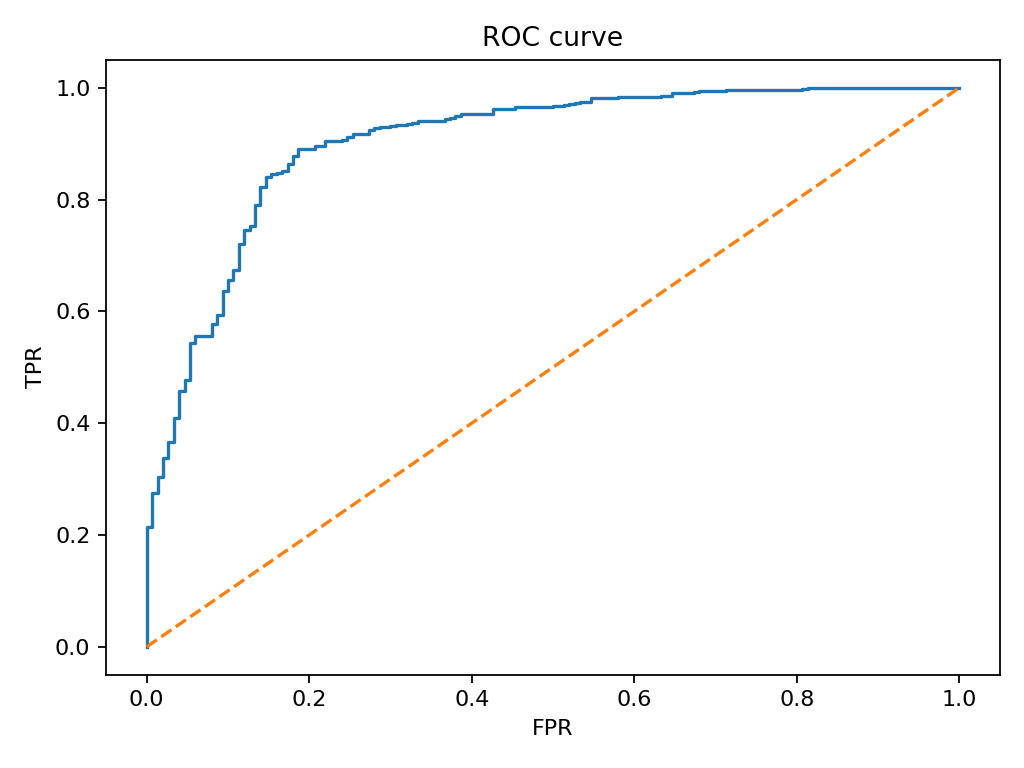

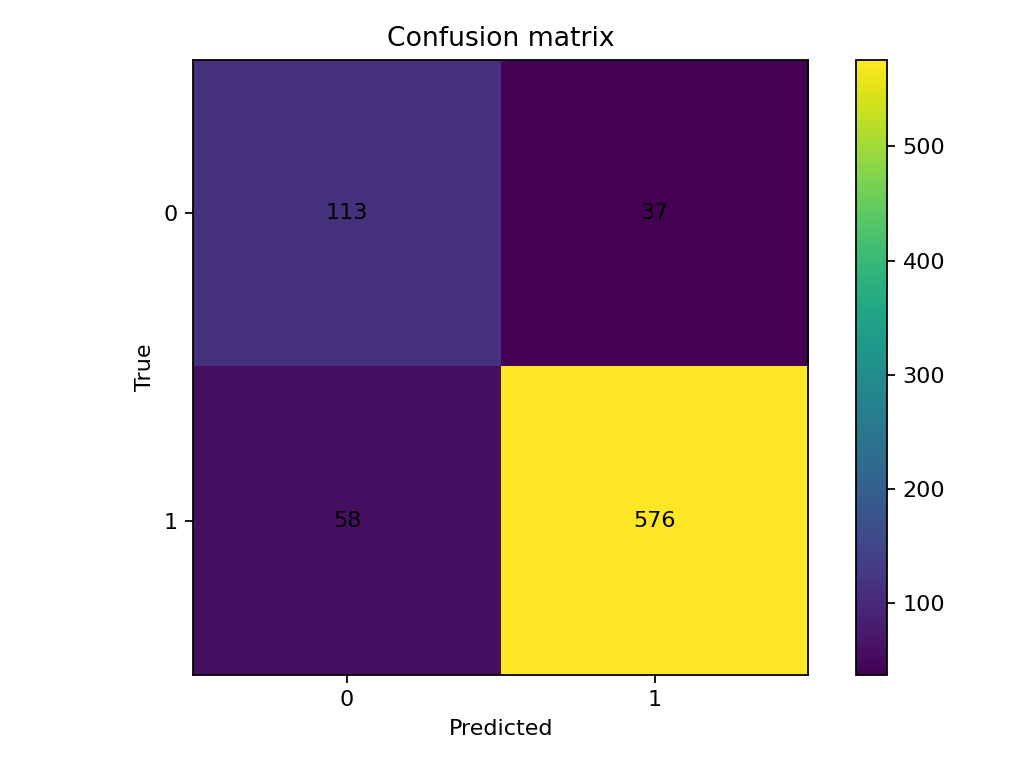

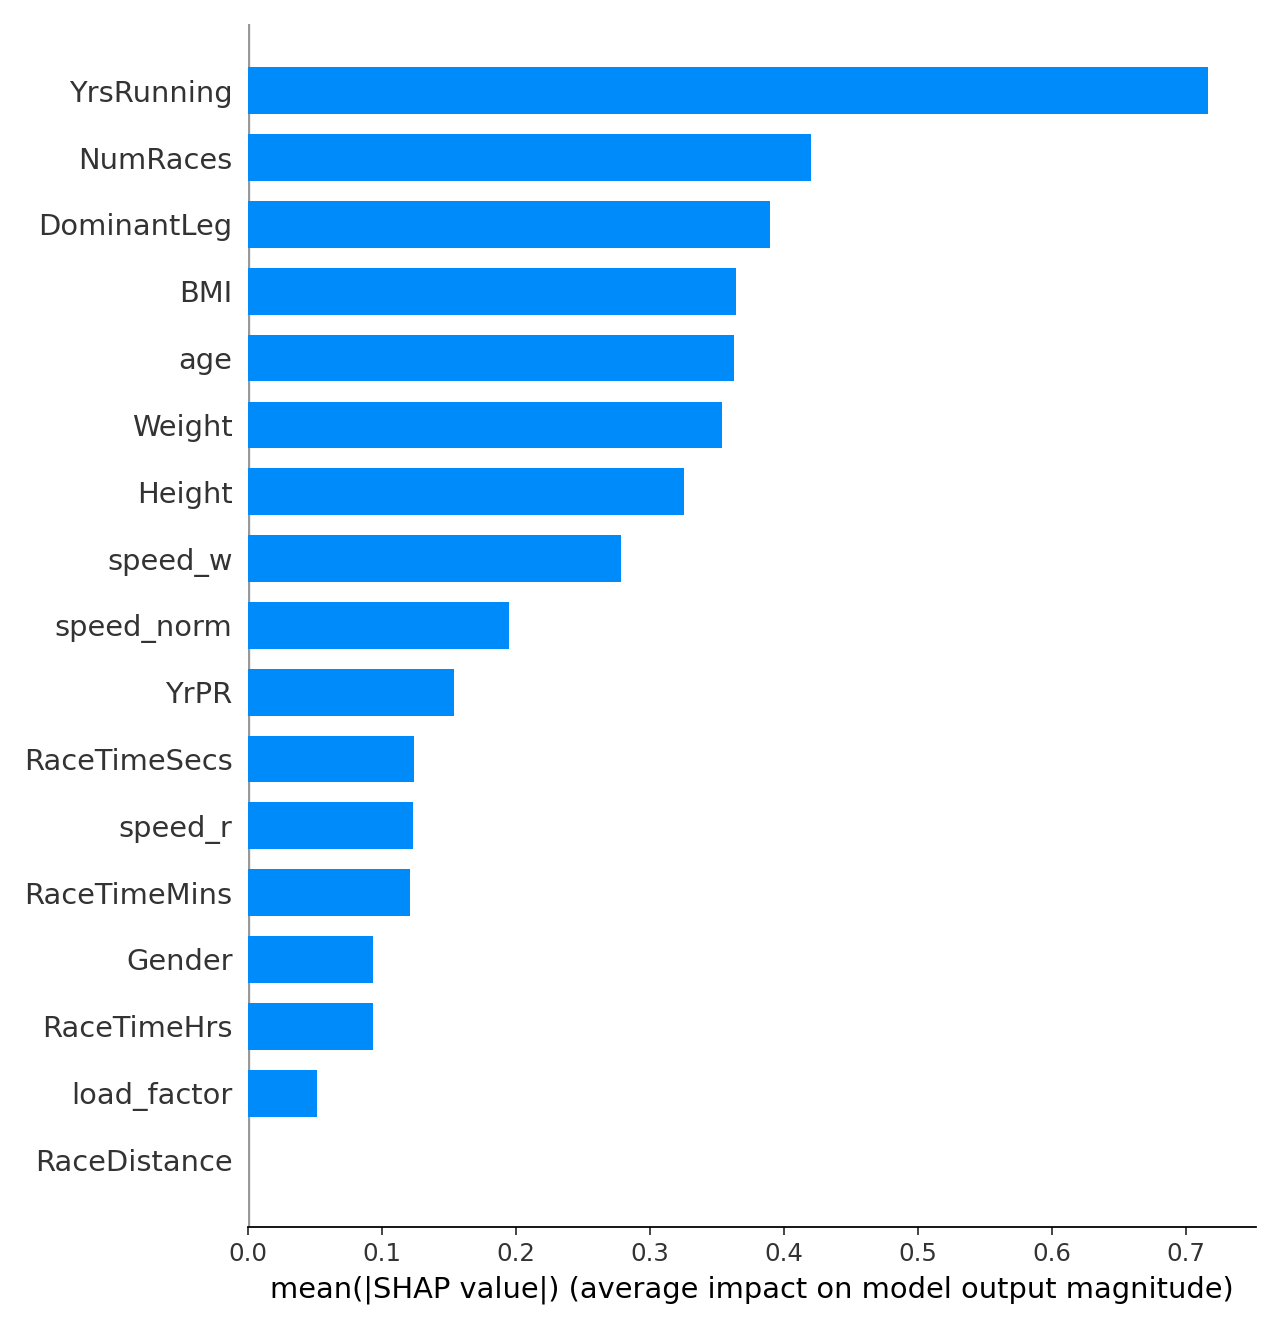

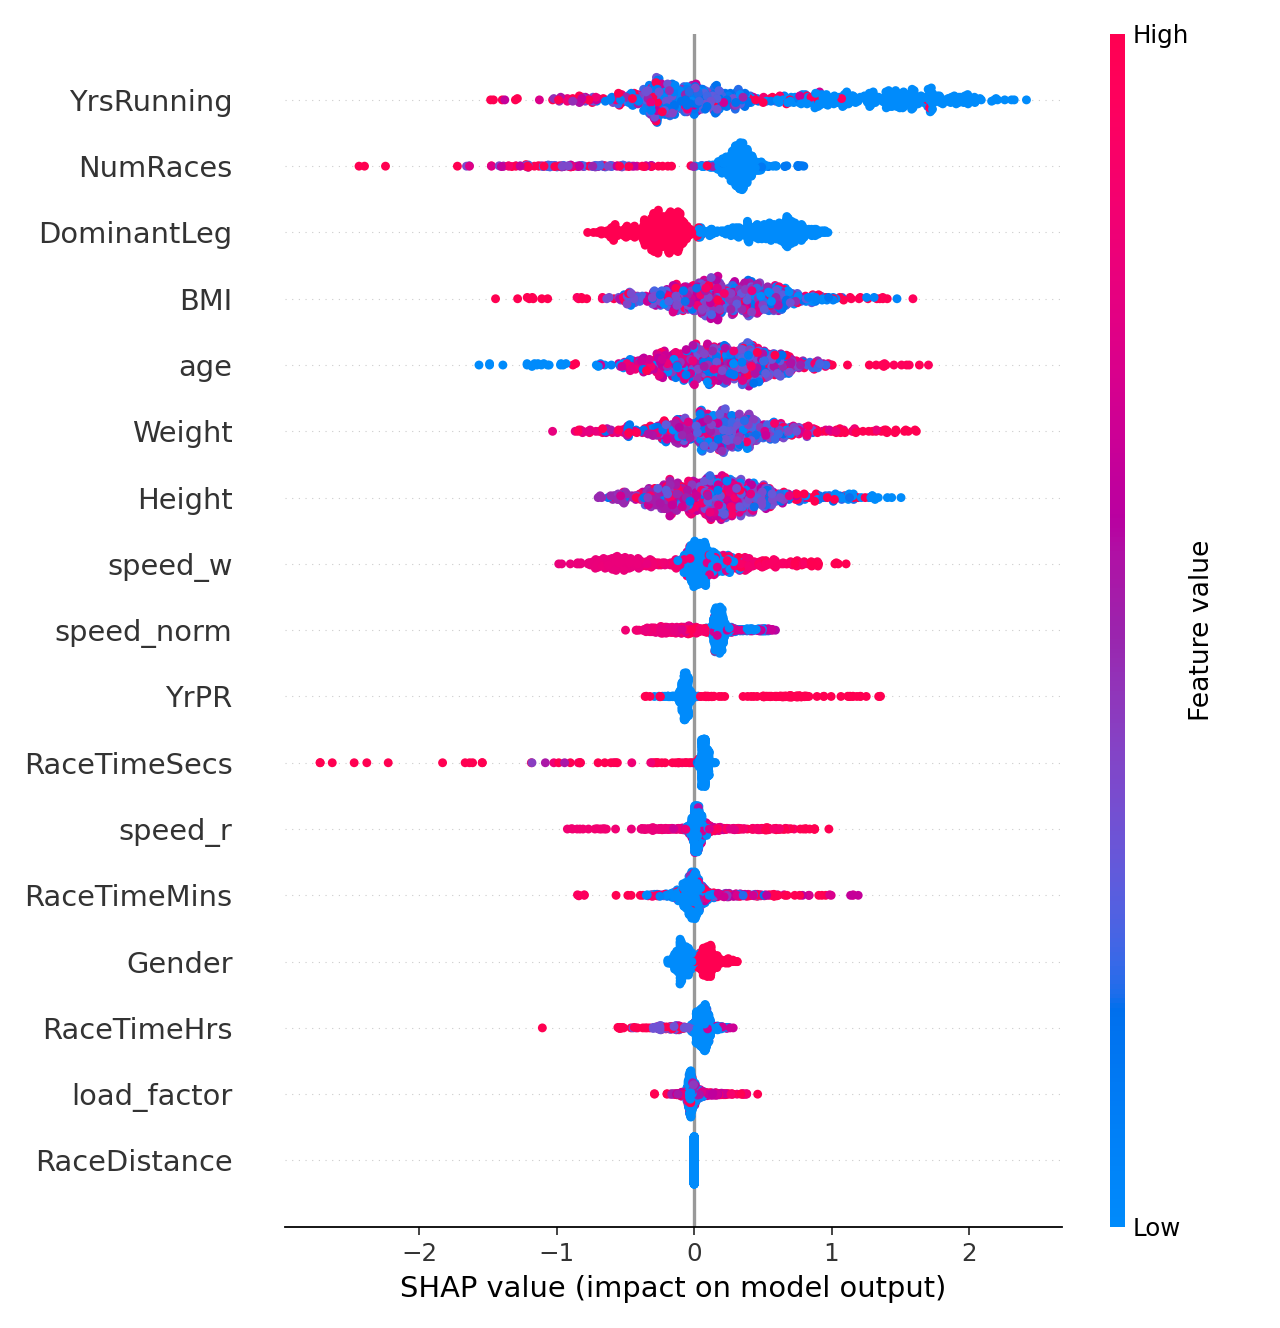

In [65]:
from IPython.display import Image, display

for name in ['roc_curve.png','confusion_matrix.png','shap_summary_bar.png','shap_beeswarm.png']:
    p = Path('artifacts')/name
    if p.exists():
        display(Image(filename=str(p)))
    else:
        print(f'Arquivo não encontrado: {name}')


## 7. Avaliação dos resultados
- Análise quantitativa: comparar RF vs XGB (AUC/F1) e erros do holdout.  
- Análise qualitativa: relação de variáveis explicativas (SHAP) com biomecânica.  
- **Limitações**: variabilidade de vídeo (ângulos/câmera), precisão do pose estimation, dados clínicos ausentes.
- **Melhorias**: coleta padronizada, aumento de amostras, normalização por altura/cadência, uso de CNN 2D/3D nos frames.


## 8. Estratégia de explicabilidade (SHAP)
- Já gerada no treino (TreeExplainer).  
- Interprete as top features no bar plot e no beeswarm.

In [66]:
# Nenhum código obrigatório aqui: os gráficos SHAP já foram
# gerados lá no passo de treino (item 5/6) e salvos em artifacts/.

## 9. Aplicação: inferência e app (opcional na apresentação)
- **Inferência por vídeo**: `infer.py` processa um vídeo e gera um `*_report.png`.  
- **App Streamlit**: `app_streamlit.py` permite upload de vídeo e parecer com probabilidade de risco.
Obs.: a extração de keypoints usa MediaPipe; certificar de ter `mediapipe` e `opencv-python` instalados.


In [74]:
"""## 9. Aplicação: inferência e app (opcional na apresentação)
- **Inferência por vídeo**: `infer.py` processa um vídeo e gera um `*_report.png`.
- **App Streamlit**: `app_streamlit.py` permite upload de vídeo e parecer com probabilidade de risco.
Obs.: a extração de keypoints usa MediaPipe; certificar de ter `mediapipe` e `opencv-python` instalados.
"""

# ====== Inferência por vídeo com fallback (infer.py -> infer_portable.py) ======
import importlib, textwrap, subprocess, sys
from pathlib import Path
from types import SimpleNamespace

# ---------------------------------------------------
# 0) Garantir pacotes no Colab: mediapipe e opencv-python
# ---------------------------------------------------
def _ensure_pkg(pkg: str):
    base = pkg.split("==")[0].split("[")[0]
    try:
        importlib.import_module(base)
        print(f"✔ {pkg} já instalado")
    except Exception:
        print(f"Instalando {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for _pkg in ["mediapipe", "opencv-python"]:
    _ensure_pkg(_pkg)

# ---------------------------------------------------
# 1) Fallback para video_pose.py
# ---------------------------------------------------
has_video = True
try:
    import video_pose  # tenta usar o módulo normal
    print("✔ Usando video_pose.py")
except ModuleNotFoundError:
    print("⚠ video_pose.py não encontrado. Criando versão portátil 'video_pose.py'...")

    video_pose_src = r"""
import cv2
import numpy as np
from mediapipe import solutions as mp_solutions

def extract_keypoints(video_path: str, max_frames: int = 900):
    mp_pose = mp_solutions.pose
    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    kps_series = {kp: [] for kp in range(33)}  # 33 pontos
    h = w = None
    frames = 0
    while cap.isOpened() and frames < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if h is None:
            h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = pose.process(rgb)
        if res.pose_landmarks:
            pts = res.pose_landmarks.landmark
            for i, p in enumerate(pts):
                kps_series[i].append((p.x, p.y))
        frames += 1
    cap.release()

    # normaliza e converte para dict com nomes
    from mediapipe.python.solutions.pose import PoseLandmark as PL
    name_map = {i: PL(i).name.lower() for i in range(33)}
    out = {}
    for i, seq in kps_series.items():
        if len(seq) == 0:
            continue
        arr = np.array(seq, dtype=np.float32)  # já normalizado [0..1]
        out[name_map[i]] = arr
    return out, fps
"""
    Path("video_pose.py").write_text(
        textwrap.dedent(video_pose_src),
        encoding="utf-8"
    )
    importlib.invalidate_caches()
    try:
        import video_pose  # agora deve existir e ter mediapipe instalado
        print("✔ Fallback OK: usando video_pose.py gerado automaticamente")
    except Exception as e:
        print("❌ Não foi possível carregar video_pose.py mesmo após criação.")
        print("   Erro técnico:", e)
        has_video = False

# ---------------------------------------------------
# 2) Fallback para features.py (versão ROBUSTA – sem ValueError)
#    ATENÇÃO: aqui usamos ''' ... """docstring""" ... '''
#    para não estourar SyntaxError
# ---------------------------------------------------
has_features = True
try:
    import features  # tenta usar o módulo normal
    print("✔ Usando features.py")
except ModuleNotFoundError:
    print("⚠ features.py não encontrado. Criando versão portátil 'features.py'...")

    features_src = '''\
import numpy as np

KEYPOINTS = [
    'nose','left_eye_inner','left_eye','left_eye_outer','right_eye_inner','right_eye','right_eye_outer',
    'left_ear','right_ear','mouth_left','mouth_right',
    'left_shoulder','right_shoulder','left_elbow','right_elbow','left_wrist','right_wrist',
    'left_pinky','right_pinky','left_index','right_index','left_thumb','right_thumb',
    'left_hip','right_hip','left_knee','right_knee','left_ankle','right_ankle',
    'left_heel','right_heel','left_foot_index','right_foot_index'
]

def _angle(a, b, c):
    """Calcula o ângulo ABC (em graus) com vértice em B."""
    ba = a - b
    bc = c - b
    cosang = np.einsum(
        "...i,...i->...", ba, bc
    ) / (np.linalg.norm(ba, axis=-1) * np.linalg.norm(bc, axis=-1) + 1e-8)
    return np.degrees(np.arccos(np.clip(cosang, -1.0, 1.0)))

def series_to_features(kps: dict, fps: float = 30.0) -> dict:
    """
    Converte dict de keypoints (nome -> array (T,2)) em features agregadas.

    Esta versão NÃO lança ValueError quando keypoints estiverem faltando.
    Retorna {} nesses casos, permitindo que a inferência trate isso de forma segura.
    """

    out = {}

    if not kps:
        print("[PisAi] Aviso: nenhum keypoint detectado no vídeo.")
        return out

    # Pontos essenciais para o modelo
    needed = [
        "left_hip","right_hip","left_knee","right_knee",
        "left_ankle","right_ankle",
        "left_shoulder","right_shoulder","nose"
    ]

    # Verifica faltantes
    missing = [k for k in needed if k not in kps]
    if missing:
        print(f"[PisAi] Aviso: keypoints faltando: {missing}")
        return out

    # Comprimento da série
    T = len(kps[needed[0]])
    if T < 10:
        print(f"[PisAi] Aviso: poucos frames detectados (T={T})")
        return out

    # Centro de massa aproximado
    com = (
        kps["left_hip"] + kps["right_hip"] +
        kps["left_shoulder"] + kps["right_shoulder"]
    ) / 4.0

    knee_l = _angle(kps["left_hip"], kps["left_knee"], kps["left_ankle"])
    knee_r = _angle(kps["right_hip"], kps["right_knee"], kps["right_ankle"])

    def aggs(name, arr):
        out[f"{name}_mean"] = float(np.nanmean(arr))
        out[f"{name}_std"]  = float(np.nanstd(arr))

    aggs("knee_l", knee_l)
    aggs("knee_r", knee_r)

    out["T"] = int(T)
    out["fps"] = float(fps)

    return out
'''
    Path("features.py").write_text(
        features_src,
        encoding="utf-8"
    )
    importlib.invalidate_caches()
    try:
        import features
        print("✔ Fallback OK: usando features.py gerado automaticamente")
    except Exception as e:
        print("❌ Não foi possível carregar features.py mesmo após criação.")
        print("   Erro técnico:", e)
        has_features = False

# ---------------------------------------------------
# 3) Fallback principal: infer.py -> infer_portable.py (com checagem de features)
# ---------------------------------------------------
spec_infer = None

# Garante que o pacote pisai_poc seja visível (igual fizemos no treino)
proj_dir = Path('.').resolve()        # /content/drive/MyDrive/PisAi_PoC_13/pisai_poc
root_dir = proj_dir.parent           # /content/drive/MyDrive/PisAi_PoC_13

if str(root_dir) not in sys.path:
    sys.path.insert(0, str(root_dir))
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

if not has_video or not has_features:
    print("⚠ Inferência NÃO será executada porque video_pose/features não carregaram.")
else:
    try:
        # 1ª tentativa: importar como pacote (respeita os imports relativos .video_pose, .features)
        try:
            spec_infer = importlib.import_module('pisai_poc.infer')
            print("✔ Usando pisai_poc.infer (pacote)")
        except ModuleNotFoundError:
            # 2ª tentativa: importar infer.py como módulo local
            spec_infer = importlib.import_module('infer')
            print("✔ Usando infer.py local")

    except (ModuleNotFoundError, ImportError) as e:
        # Se der qualquer erro (inclusive attempted relative import) → criar infer_portable.py
        print("⚠ Não consegui usar infer original:", e)
        print("   Criando e usando 'infer_portable.py' como fallback...")

        infer_portable_src = r"""
import argparse, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from video_pose import extract_keypoints
from features import series_to_features

def main(args):
    video = Path(args.video)
    artifacts = Path(args.artifacts)
    outdir = Path(args.out); outdir.mkdir(parents=True, exist_ok=True)

    model = load(artifacts / "model.joblib")
    with open(artifacts / "feature_columns.json","r",encoding="utf-8") as f:
        feat_cols = json.load(f)

    # Extrai keypoints do vídeo
    kps, fps = extract_keypoints(str(video))

    # Converte a série de keypoints em features agregadas (robustas)
    feats = series_to_features(kps, fps=fps)
    if not feats:
        print("[PisAi] Não foi possível extrair features válidas deste vídeo.")
        print("       Verifique se o corredor aparece de corpo inteiro e em movimento contínuo.")
        return

    df = pd.DataFrame([feats], index=[0])

    # Garante que todas as colunas esperadas existam
    for c in feat_cols:
        if c not in df.columns:
            df[c] = 0.0
    df = df[feat_cols]

    # Faz a previsão
    proba = model.predict_proba(df)[:, 1]
    label = int(proba[0] >= 0.5)
    txt = "Com risco" if label == 1 else "Técnica adequada"
    print(f"Resultado: {txt} (prob={proba[0]:.2f})")

    # Gera gráfico simples das features e salva como PNG
    fig = plt.figure()
    plt.title(f"PisAi – Resultado: {txt} (p={proba[0]:.2f})")
    plt.bar(range(len(df.columns)), df.values[0])
    plt.xticks(
        range(len(df.columns)),
        [c.replace('_','\\n') for c in df.columns],
        rotation=90,
    )
    plt.tight_layout()
    imgp = outdir / (video.stem + "_report.png")
    fig.savefig(imgp, dpi=160)
    print(f"Relatório salvo em {imgp}")
"""
        Path('infer_portable.py').write_text(
            textwrap.dedent(infer_portable_src),
            encoding='utf-8'
        )
        importlib.invalidate_caches()
        try:
            spec_infer = importlib.import_module('infer_portable')
            print("✔ Fallback OK: usando infer_portable.py")
        except Exception as e2:
            print("❌ Não foi possível importar infer_portable.py.")
            print("   Erro técnico:", e2)
            spec_infer = None


    # ---------------------------------------------------
    # 4) INPUT: solicitar vídeo ao usuário no Colab
    # ---------------------------------------------------
    if spec_infer is not None:
        from google.colab import files

        print("\n📂 Selecione o vídeo para análise (MP4, AVI, MOV):")
        uploaded = files.upload()

        if not uploaded:
            print("❌ Nenhum vídeo foi carregado. A inferência não será executada.")
        else:
            video_name = list(uploaded.keys())[0]
            print(f"✔ Vídeo carregado: {video_name}")

            # Salvar o vídeo no diretório atual
            video_path = f"./{video_name}"
            print(f"➡ Salvando vídeo em: {video_path}")

            with open(video_path, "wb") as f:
                f.write(uploaded[video_name])

            # ---------------------------------------------------
            # 5) Executar inferência apenas se tudo estiver OK
            # ---------------------------------------------------
            args = SimpleNamespace(
                video=video_path,
                artifacts='artifacts',
                out='reports',
            )

            print("\n🔎 Iniciando inferência no vídeo carregado...")
            spec_infer.main(args)
            print("\n📊 Relatório gerado em: reports/")
    else:
        print("❌ Inferência não executada (não foi possível carregar infer.py nem infer_portable.py).")

# Rodar o app Streamlit (local). Execute em um terminal:
print("streamlit run app_streamlit.py")


✔ mediapipe já instalado
Instalando opencv-python ...
✔ Usando video_pose.py
✔ Usando features.py
✔ Usando pisai_poc.infer (pacote)

📂 Selecione o vídeo para análise (MP4, AVI, MOV):


KeyboardInterrupt: 

In [68]:
# Rodar o app Streamlit (local). Execute em um terminal:
print('streamlit run app_streamlit.py')


streamlit run app_streamlit.py


## 10. Conclusão
- O pipeline atinge desempenho competitivo em AUC e oferece interpretabilidade com SHAP.  
- Viabilidade prática: triagem inicial e apoio ao treinador/fisioterapeuta.  
- Próximos passos: coleta padronizada, calibração clínica e estudos prospectivos.


## 11. Referências

**Documentação Técnica**

- GOOGLE. *MediaPipe Pose Landmarker: Pose landmark detection with Machine Learning.*  
  Disponível em: [https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker](https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker).  
  Acesso em: set. 2025.

---

**Literatura Científica**



**Repositório do Projeto**

- AZEVEDO, J. C. A. *PisAi: Análise de marcha e predição de lesões com visão computacional e aprendizado de máquina.*  
  Repositório GitHub: [https://github.com/jcazti/Poc_Pisai](https://github.com/jcazti/Poc_Pisai).  
  Acesso em: nov. 2025.
